[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025_2/blob/main/analysis_scripts/Real_Data_Exploratory.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025_2.git
%cd /content/OP_2025_2/

In [ ]:
!pip install -qr requirements.txt

# Packages and functions

In [1]:
import os
import time
import umap
import random
import numpy as np
import pandas as pd
import colorsys as cs
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.spatial import procrustes, distance_matrix
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cdist
import scipy
import tools as tl
import scanpy as sc
from sklearn.metrics.pairwise import cosine_similarity
import anndata as ad

def get_pa(pos_recon, pos_truth):
    pos_recon = pd.DataFrame(pos_recon, columns = [['xcoord','ycoord']])
    mtx1, mtx2, disparity = procrustes(pos_truth[['xcoord','ycoord']], pos_recon[['xcoord','ycoord']])
    
    pos_truth_translate = pos_truth.copy()
    pos_truth_translate['xcoord'] = pos_truth_translate['xcoord'] - np.mean(pos_truth_translate['xcoord'])
    pos_truth_translate['ycoord'] = pos_truth_translate['ycoord'] - np.mean(pos_truth_translate['ycoord'])
    
    scaling = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))
    scaling_2 = np.sqrt(np.trace(np.dot(pos_truth_translate[['xcoord','ycoord']], pos_truth_translate[['xcoord','ycoord']].T)))/np.sqrt(np.trace(np.dot(mtx2, mtx2.T)))

    mtx1_scaled = mtx1*scaling
    mtx2_scaled = mtx2*scaling_2
    
    return mtx2_scaled

# Generate Simulation Data

In [2]:
np.random.seed(42)

# simulation parameters
n_a = 10000 # capture
n_t = 10000 # fiducial
RADIUS = 1500
sigma = 300
UMI = 2400

# generate coordinates for capture and fiducial
r_vals = np.sqrt(np.random.uniform(size=n_t)) * RADIUS
thet_vals = np.random.uniform(size=n_t) * 2 * np.pi
coords_t_truth = np.column_stack((r_vals * np.cos(thet_vals), r_vals * np.sin(thet_vals)))
coords_t_truth = coords_t_truth.astype(float)
r_vals = np.sqrt(np.random.uniform(size=n_a)) * RADIUS
thet_vals = np.random.uniform(size=n_a) * 2 * np.pi
coords_a_truth = np.column_stack((r_vals * np.cos(thet_vals), r_vals * np.sin(thet_vals)))
coords_a_truth = coords_a_truth.astype(float)

distances = cdist(coords_a_truth, coords_t_truth)
proba = np.exp(-distances**2 / (2*sigma**2))
proba = proba / proba.sum(axis=1, keepdims=True)

# simulate counts data
sim_counts = np.zeros((n_a, n_t))
for i in range(n_a):
    sim_counts[i,:] = np.random.multinomial(UMI, proba[i,:])

In [3]:
sim_adata = ad.AnnData(sim_counts, obs = pd.DataFrame(coords_a_truth, columns=['xcoord', 'ycoord']), var = pd.DataFrame(coords_t_truth, columns=['xcoord', 'ycoord']))


sim_cos_counts = cosine_similarity(sim_adata.X)
sim_truth_dist = distance_matrix(sim_adata.obs.copy().values, sim_adata.obs.copy().values)
sim_truth_dist

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


array([[   0.        , 1159.18190171, 1862.05262931, ..., 1431.73747569,
        1359.50270188, 1040.31085885],
       [1159.18190171,    0.        , 1527.26532332, ...,  599.36490344,
         329.23976367,  169.99005147],
       [1862.05262931, 1527.26532332,    0.        , ...,  974.19277698,
        1824.79466219, 1639.91897528],
       ...,
       [1431.73747569,  599.36490344,  974.19277698, ...,    0.        ,
         862.0717136 ,  747.68839972],
       [1359.50270188,  329.23976367, 1824.79466219, ...,  862.0717136 ,
           0.        ,  339.70681197],
       [1040.31085885,  169.99005147, 1639.91897528, ...,  747.68839972,
         339.70681197,    0.        ]])

# Load Real Data

In [4]:
import scipy.sparse as sp 
from collections import Counter
import editdistance

# generate spase matrix from matching, with selection on anchor and target
def get_matrix(match_df,min_a_cnt,max_a_cnt, min_t_cnt,max_t_cnt, anchor, target):
    a_all = match_df.groupby(anchor)['cnt'].sum().reset_index(name='total_cnt')  
    a_sel = a_all.loc[(a_all['total_cnt']>min_a_cnt) & (a_all['total_cnt']<max_a_cnt),]
    t_all = match_df.groupby(target)['cnt'].sum().reset_index(name='total_cnt')  
    t_sel = t_all.loc[(t_all['total_cnt']>min_t_cnt) & (t_all['total_cnt']<max_t_cnt),]
    match_df = match_df[(match_df[anchor].isin(a_sel[anchor])) & (match_df[target].isin(t_sel[target]))]
    a_list = match_df.groupby(anchor)['cnt'].sum().reset_index(name='total_cnt') 
    t_list = match_df.groupby(target)['cnt'].sum().reset_index(name='total_cnt') 
    print('a: {}'.format(len(a_list)))
    print('t: {}'.format(len(t_list)))
    a_dict = dict()
    t_dict = dict()
    for i in range(len(a_list)):
        a_dict[a_list.iloc[i,0]] = i
    for j in range(len(t_list)):
        t_dict[t_list.iloc[j,0]] = j
    a_coo = []
    t_coo = []
    [a_coo.append(a_dict[a]) for a in match_df[anchor]]
    [t_coo.append(t_dict[t]) for t in match_df[target]]
    counts_coo = sp.coo_matrix((match_df['cnt'], (a_coo, t_coo)))
    # counts = counts_coo.tocsr().toarray()
    counts = counts_coo.tocsr()
    return counts, a_list, t_list

def build_6mer_dist(bc_list):
    start_km = {}
    mid_km = {}
    end_km = {}
    for bc in bc_list:
        start_km.setdefault(bc[:6] , []).append(bc)
        mid_km.setdefault(bc[4:10], []).append(bc)
        end_km.setdefault(bc[-6:] , []).append(bc)
    return start_km,mid_km,end_km

def barcode_matching(bc_pos_dict,spatial_bc_list,max_dist=1):
    bc_matching_dict = {}
    def get_sel_bc(bc):
        res = []
        if bc[:6] in start_km:
            res += start_km[bc[:6]]
        if bc[-6:] in end_km:
            res += end_km[bc[-6:]]
        if bc[4:10] in mid_km:
            res += mid_km[bc[4:10]]
        return set(res)
    exact_match = 0
    fuzzy_match = 0
    bc_ref_list = list(bc_pos_dict.keys())
    start_km,mid_km,end_km = build_6mer_dist(bc_ref_list)
    for bc in spatial_bc_list:
        bc_old = bc
        #bc = "".join([bc[it] for it in [1,2,3,4,5,6,7,9,10,11,12,13] ])
        if bc in bc_pos_dict:
            exact_match += 1
            bc_matching_dict[bc_old] = bc
        else:
            sel_bc = get_sel_bc(bc)
            #sel_bc = bc_ref_list
            if len(sel_bc)>0:
                fz = [(it, editdistance.eval(it, bc)) for it in sel_bc]
                fz = [it for it in fz if it[1]<=max_dist]
                fz.sort(key=lambda x:x[1])
                if len(fz)==0:
                    continue
                ## if there are two barcodes with the same edit distance, choose the one with higher error rate in the last base
                if len(fz)>1 and fz[0][1]==fz[1][1]:
                    if editdistance.eval(fz[0][0][:-1], bc[-1])>editdistance.eval(fz[1][0][:-1], bc[-1]):  # higher error rate in the last base of the barcode
                        fuzzy_match += 1
                        bc_matching_dict[bc_old] = fz[1][0]
                    elif editdistance.eval(fz[0][0][:-1], bc[-1])<editdistance.eval(fz[1][0][:-1], bc[-1]):
                        fuzzy_match += 1
                        bc_matching_dict[bc_old] = fz[0][0]
                else:
                    fuzzy_match += 1
                    bc_matching_dict[bc_old] = fz[0][0]
    return bc_matching_dict,exact_match,fuzzy_match

In [ ]:
anchor = 'V10' #anchor beads as the bead type what we want coordinates, the polyT beads in Slide-seq and polyA beads in Slide-tags
target = 'V9A30' #target beads as the bead type whose coordinates won't be used in spatial transcriptomics

# load barcode-barcode conjugation information
blind_raw = pd.read_csv('../data/c58_8_blind_raw_reads_filtered.csv.gz', compression='gzip')
blind_sum = blind_raw.groupby(['R1_bc', 'R2_bc']).sum().reset_index()[['R1_bc', 'R2_bc', 'reads']]
blind_sum.columns = [anchor,target,'cnt']

# statistics of umi per bead
a_all = blind_sum.groupby(anchor)['cnt'].sum().reset_index(name='total_cnt')
t_all = blind_sum.groupby(target)['cnt'].sum().reset_index(name='total_cnt')

# statistics of covered bead per bead
a_cover_bc = blind_sum.groupby(anchor).count()
t_cover_bc = blind_sum.groupby(target).count()

blind_sum.head()

,V10,V9A30,cnt
0,AAAAAAAGTCTGGT,AAAGCTCTGCGAGA,1
1,AAAAAAAGTCTGGT,AAAGGATCTTCTGC,1
2,AAAAAAAGTCTGGT,AAATGTCTGATGGG,1
3,AAAAAAAGTCTGGT,AACAAGGTACACAG,1
4,AAAAAAAGTCTGGT,AACGAGGAGGTCGC,3


In [ ]:
# load beads ground truth location from in situ sequencing, center to (0,0), and scale from pixel to um
pos = pd.read_csv('../data/c58_8_matched_bead_location.csv.gz', compression='gzip')
pos['xcoord'] = pos['xcoord']-np.mean(pos['xcoord']) # ~2563
pos['ycoord'] = pos['ycoord']-np.mean(pos['ycoord']) # ~2580
pos['xcoord'] = pos['xcoord']*0.72
pos['ycoord'] = pos['ycoord']*0.72
RADIUS=np.mean((pos[['xcoord', 'ycoord']].max() - pos[['xcoord', 'ycoord']].min())/2)
print(RADIUS)

1536.9462


In [7]:
time0 = time.time()
# define filtering of beads based on minmum or maximum count per bead
a_min = 0
a_max = 100000
t_min = 0
t_max = 100000

# construct anchor by target diffusion matrix
counts_temp, a_temp, t_temp = get_matrix(blind_sum, min_a_cnt=a_min, max_a_cnt=a_max, min_t_cnt=t_min, max_t_cnt=t_max, anchor=anchor, target=target)

a: 19408
t: 19681


In [8]:
# Barcode filtering
a_match_dict,_,_= barcode_matching(Counter(pos['barcode']), a_temp[anchor].values, max_dist = 1)
t_match_dict,_,_= barcode_matching(Counter(pos['barcode']), t_temp[target].values, max_dist = 1)


a_match_df = pd.DataFrame({'barcode':a_match_dict.keys(),
              'matched':a_match_dict.values()})
t_match_df = pd.DataFrame({'barcode':t_match_dict.keys(),
              'matched':t_match_dict.values()})
a_sel = a_temp[a_temp[anchor].isin(a_match_df.matched.unique())]
t_sel = t_temp[t_temp[target].isin(t_match_df.matched.unique())]
counts = pd.DataFrame(counts_temp.toarray()).loc[a_temp[anchor].isin(a_match_df.matched.unique()), t_temp[target].isin(t_match_df.matched.unique())].values

print(a_sel.shape, t_sel.shape)
a_sel = pd.merge(a_sel, pos, how = 'left', left_on = anchor, right_on='barcode')
t_sel = pd.merge(t_sel, pos, how = 'left', left_on = target, right_on='barcode')
print(a_sel.shape, t_sel.shape)

(12033, 2) (12789, 2)
(12033, 5) (12789, 5)


In [9]:
adata = ad.AnnData(counts, obs = a_sel, var = t_sel)
# filter to those with ground truth info
adata = adata[~adata.obs.xcoord.isna(),~adata.var.xcoord.isna()]
# filter to those with relevant number of counts
adata = adata[np.max(adata.X, axis=1) > 10, np.max(adata.X, axis=0) > 10]
adata.obs = adata.obs.reset_index(drop=True).set_index('barcode')[['xcoord', 'ycoord']]
adata.var = adata.var.reset_index(drop=True).set_index('barcode')[['xcoord', 'ycoord']]
adata

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 12030 × 12786
    obs: 'xcoord', 'ycoord'
    var: 'xcoord', 'ycoord'

In [10]:
import scanpy as sc
from sklearn.metrics.pairwise import cosine_similarity

cos_counts = cosine_similarity(adata.X)

In [11]:
counts = adata.X
adata.obs = adata.obs.reset_index().set_index('barcode')[['xcoord', 'ycoord']]
adata.var = adata.var.reset_index().set_index('barcode')[['xcoord', 'ycoord']]
adata

AnnData object with n_obs × n_vars = 12030 × 12786
    obs: 'xcoord', 'ycoord'
    var: 'xcoord', 'ycoord'

In [12]:
truth_dist = distance_matrix(adata.obs.copy().values, adata.obs.copy().values)
truth_dist

array([[   0.        ,  951.53860069, 2299.77513541, ..., 1391.52964053,
        1994.10584921,  485.64418441],
       [ 951.53860069,    0.        , 1557.16157127, ...,  981.68055366,
        1255.03295829,  504.53746086],
       [2299.77513541, 1557.16157127,    0.        , ..., 1011.46449769,
         308.69734459, 1999.73779   ],
       ...,
       [1391.52964053,  981.68055366, 1011.46449769, ...,    0.        ,
         750.73223008, 1233.38701126],
       [1994.10584921, 1255.03295829,  308.69734459, ...,  750.73223008,
           0.        , 1691.45801515],
       [ 485.64418441,  504.53746086, 1999.73779   , ..., 1233.38701126,
        1691.45801515,    0.        ]])

In [17]:
counts.sum(axis=1).mean()

np.float64(2497.662011637573)

# Run UMAP 

In [27]:
time_start = time.time()
reducer = umap.UMAP(metric='cosine',
                    n_neighbors=25, 
                    min_dist=0.99, 
                    low_memory=False, 
                    n_components=2, 
                    verbose=True,           
                    n_epochs=10000,                    
                    learning_rate = 1)
embedding = reducer.fit_transform(adata.X)
time_loop = time.time()
print('umap time: ', time_loop-time_start)

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, learning_rate=1, low_memory=False, metric='cosine', min_dist=0.99, n_epochs=10000, n_neighbors=25, verbose=True)
Tue Dec 16 15:47:35 2025 Construct fuzzy simplicial set
Tue Dec 16 15:47:35 2025 Finding Nearest Neighbors
Tue Dec 16 15:47:35 2025 Building RP forest with 10 trees
Tue Dec 16 15:47:38 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Dec 16 15:47:52 2025 Finished Nearest Neighbor Search
Tue Dec 16 15:47:54 2025 Construct embedding


Epochs completed:   0%|            0/10000 [00:00]

	completed  0  /  10000 epochs
	completed  1000  /  10000 epochs
	completed  2000  /  10000 epochs
	completed  3000  /  10000 epochs
	completed  4000  /  10000 epochs
	completed  5000  /  10000 epochs
	completed  6000  /  10000 epochs
	completed  7000  /  10000 epochs
	completed  8000  /  10000 epochs
	completed  9000  /  10000 epochs
Tue Dec 16 15:48:29 2025 Finished embedding
umap time:  54.97380208969116


In [28]:
sim_embedding = reducer.fit_transform(sim_adata.X)

UMAP(angular_rp_forest=True, learning_rate=1, low_memory=False, metric='cosine', min_dist=0.99, n_epochs=10000, n_neighbors=25, verbose=True)


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Tue Dec 16 15:48:29 2025 Construct fuzzy simplicial set
Tue Dec 16 15:48:30 2025 Finding Nearest Neighbors
Tue Dec 16 15:48:30 2025 Building RP forest with 10 trees
Tue Dec 16 15:48:30 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Tue Dec 16 15:48:33 2025 Finished Nearest Neighbor Search
Tue Dec 16 15:48:33 2025 Construct embedding


Epochs completed:   0%|            0/10000 [00:00]

	completed  0  /  10000 epochs
	completed  1000  /  10000 epochs
	completed  2000  /  10000 epochs
	completed  3000  /  10000 epochs
	completed  4000  /  10000 epochs
	completed  5000  /  10000 epochs
	completed  6000  /  10000 epochs
	completed  7000  /  10000 epochs
	completed  8000  /  10000 epochs
	completed  9000  /  10000 epochs
Tue Dec 16 15:49:09 2025 Finished embedding


# Evaluate neighbor metrics of core dataset

In [21]:
from sklearn.neighbors import KDTree
from numba import njit

@njit
def unique_sorted(a):
    """Return unique sorted values of array a (Numba-compatible)."""
    a = np.sort(a)
    out = [a[0]]
    for i in range(1, a.size):
        if a[i] != a[i-1]:
            out.append(a[i])
    return np.array(out)

@njit
def count_intersection(a, b):
    """Count unique intersection between two sorted unique arrays."""
    i = j = count = 0
    na, nb = a.size, b.size
    while i < na and j < nb:
        if a[i] == b[j]:
            count += 1
            i += 1
            j += 1
        elif a[i] < b[j]:
            i += 1
        else:
            j += 1
    return count

@njit
def count_union_size(a, b):
    """Count unique union size of two sorted unique arrays."""
    i = j = count = 0
    na, nb = a.size, b.size
    while i < na and j < nb:
        if a[i] == b[j]:
            count += 1
            i += 1
            j += 1
        elif a[i] < b[j]:
            count += 1
            i += 1
        else:
            count += 1
            j += 1
    # Add remaining items
    count += (na - i) + (nb - j)
    return count

@njit
def jaccard_distance_numeric_numba(X, Y):
    n = X.shape[0]
    out = np.empty(n, dtype=np.float64)

    for idx in range(n):
        x = unique_sorted(X[idx])
        y = unique_sorted(Y[idx])

        inter = count_intersection(x, y)
        union = count_union_size(x, y)

        out[idx] = 1.0 - (inter / union if union != 0 else 0.0)

    return out


In [22]:
bar_n = adata.obs.shape[0]

embed_list = [cos_counts]
name_list = ['Cosine Similarity of Real Data']
jac_list = []
nn_df_list = []
method_list = []
nn_list = np.arange(2, 100, 1).tolist() 

truth_tree = KDTree(adata.obs[['xcoord', 'ycoord']].values)

for nn in nn_list:
    distances, truth_nn = truth_tree.query(adata.obs[['xcoord', 'ycoord']].values, k=nn)
    for c, name in zip(embed_list, name_list):
        test = c.argsort(axis=1)[:, ::-1]
        # ignore self
        jac_list += jaccard_distance_numeric_numba(truth_nn[:, 1:nn], test[:, 1:nn]).tolist() 
        nn_df_list += bar_n*[nn-1]
        method_list += bar_n*[name]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [23]:
bar_n = sim_adata.obs.shape[0]

embed_list = [sim_cos_counts]
name_list = ['Cosine Similarity of Sim Data']

truth_tree = KDTree(sim_adata.obs[['xcoord', 'ycoord']].values)

for nn in nn_list:
    distances, truth_nn = truth_tree.query(sim_adata.obs[['xcoord', 'ycoord']].values, k=nn)
    for c, name in zip(embed_list, name_list):
        test = c.argsort(axis=1)[:, ::-1]
        # ignore self
        jac_list += jaccard_distance_numeric_numba(truth_nn[:, 1:nn], test[:, 1:nn]).tolist() 
        nn_df_list += bar_n*[nn-1]
        method_list += bar_n*[name]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [45]:
embed_list = [embedding, sim_embedding]
name_list = ['UMAP Embedding of Real Data', 'UMAP Embedding of Sim Data']
truth_list = [adata.obs[['xcoord', 'ycoord']].values, sim_adata.obs[['xcoord', 'ycoord']].values]

jac_list = []
nn_df_list = []
method_list = []

for embed, name, ref in zip(embed_list, name_list, truth_list):
    print(name)
    embed_tree = KDTree(embed)
    truth_tree = KDTree(ref)
    bar_n = ref.shape[0]
    for nn in nn_list:
        distances, truth_nn = truth_tree.query(ref, k=nn)

        distances, test_nn = embed_tree.query(embed, k=nn)
        # ignore self
        jac_list += jaccard_distance_numeric_numba(truth_nn[:, 1:nn], test_nn[:, 1:nn]).tolist()
        nn_df_list += bar_n*[nn-1]
        method_list += bar_n*[name]

UMAP Embedding of Real Data
12030 12030 12030
24060 24060 24060
36090 36090 36090
48120 48120 48120
60150 60150 60150
72180 72180 72180
84210 84210 84210
96240 96240 96240
108270 108270 108270
120300 120300 120300
132330 132330 132330
144360 144360 144360
156390 156390 156390
168420 168420 168420
180450 180450 180450
192480 192480 192480
204510 204510 204510
216540 216540 216540
228570 228570 228570
240600 240600 240600
252630 252630 252630
264660 264660 264660
276690 276690 276690
288720 288720 288720
300750 300750 300750
312780 312780 312780
324810 324810 324810
336840 336840 336840
348870 348870 348870
360900 360900 360900
372930 372930 372930
384960 384960 384960
396990 396990 396990
409020 409020 409020
421050 421050 421050
433080 433080 433080
445110 445110 445110
457140 457140 457140
469170 469170 469170
481200 481200 481200
493230 493230 493230
505260 505260 505260
517290 517290 517290
529320 529320 529320
541350 541350 541350
553380 553380 553380
565410 565410 565410
577440 57

In [51]:
median_nn = pd.DataFrame({'nn':nn_df_list,
                         'method':method_list,
                         'jac':jac_list})

median_nn.head()

,nn,method,jac
0,1,UMAP Embedding of Real Data,0.0
1,1,UMAP Embedding of Real Data,1.0
2,1,UMAP Embedding of Real Data,1.0
3,1,UMAP Embedding of Real Data,1.0
4,1,UMAP Embedding of Real Data,1.0


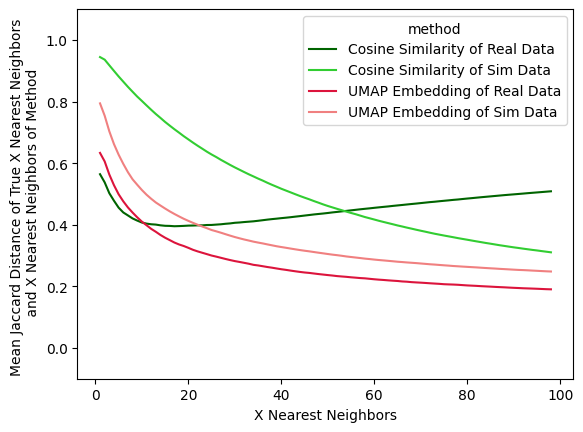

In [55]:
ax = sns.lineplot(median_nn.groupby(['method', 'nn']).mean().reset_index(), x = 'nn', y = 'jac', hue = 'method',
                  palette = {'Cosine Similarity of Real Data': 'darkgreen', 
       'Cosine Similarity of Sim Data' : 'limegreen',
                            'UMAP Embedding of Real Data': 'crimson', 
                            'UMAP Embedding of Sim Data': 'lightcoral', }
         )
#sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1.02, 1))
ax.set_xlabel('X Nearest Neighbors')
ax.set_ylabel('Mean Jaccard Distance of True X Nearest Neighbors \n and X Nearest Neighbors of Method')
plt.ylim(-.1, 1.1)
plt.savefig('final_figures/Supp3a.png')
plt.show()

# 10 nearest neighbors with jaccard distance > .5

Corresponds to 30+% of neighbors incorrect

In [101]:
nn_test = 10
jac_threshold = .5
print(np.sort(median_nn[median_nn['nn'] == nn_test].jac.unique()))

median_nn['test_col'] = median_nn['jac'] > jac_threshold

median_nn[median_nn['nn'] == nn_test].groupby('method').sum()['test_col']/median_nn[median_nn['nn'] == nn_test].groupby('method').count()['test_col']

[0.         0.18181818 0.33333333 0.46153846 0.57142857 0.66666667
 0.75       0.82352941 0.88888889 0.94736842 1.        ]


method
Cosine Similarity of Real Data    0.229011
Cosine Similarity of Sim Data     0.974500
UMAP Embedding of Real Data       0.250873
UMAP Embedding of Sim Data        0.497900
Name: test_col, dtype: float64

# Compare General Concordance of nns

In [60]:
np.mean(np.sum(cos_counts > .1, axis=0))

np.float64(16.46616791354946)

In [83]:
nn_test = 50
nn_test +=1

In [84]:
cos_rank = cos_counts.argsort(axis=1)[:, ::-1]
cos_rank = cos_rank[:, 1:nn_test]
cos_rank

array([[ 9809,  2376,  2368, ...,  2430,   902, 11419],
       [ 1744,  2970,  8924, ...,  2328,   581,  6547],
       [ 1048, 11669,  7674, ...,  4588,  6586,  1679],
       ...,
       [ 6992,  7760, 10510, ...,  5052,  6495,  3111],
       [ 3869,  6846,  5427, ...,  9595,  7318, 11312],
       [ 1687,   214,  6809, ..., 11965,   310,  9930]])

In [85]:
distances, truth_nn = KDTree(adata.obs[['xcoord', 'ycoord']].values).query(adata.obs[['xcoord', 'ycoord']].values, k=nn_test)
truth_nn = truth_nn[:, 1:nn_test]
truth_nn

array([[ 2368,  2376,  9809, ...,  8921,  2878,  7486],
       [ 7409,  7408,  1744, ...,  4548,  4853,  7481],
       [ 4512, 11669,  1531, ...,  6741,  3632,  3236],
       ...,
       [ 6992,  7760, 10510, ...,  3275, 10916,  1689],
       [ 6846,  3869, 10693, ..., 11533,  3935,  9455],
       [ 1687,   214,   641, ...,  8210,  7529, 11965]])

In [86]:
cos_rank.shape, truth_nn.shape

((12030, 50), (12030, 50))

In [87]:
real_cos = cos_counts[np.arange(cos_counts.shape[0])[:, np.newaxis], cos_rank]
real_cos

array([[0.48632675, 0.46679292, 0.34909284, ..., 0.01514881, 0.01508459,
        0.01494073],
       [0.91472408, 0.52505537, 0.49331887, ..., 0.03190612, 0.03026521,
        0.02997675],
       [0.75888656, 0.60463606, 0.49960477, ..., 0.03154983, 0.03017815,
        0.02944413],
       ...,
       [0.80561636, 0.73376644, 0.42278928, ..., 0.01692587, 0.0162287 ,
        0.01602956],
       [0.8474868 , 0.65416914, 0.54730421, ..., 0.06600815, 0.06576587,
        0.0648867 ],
       [0.92258568, 0.82167846, 0.72163817, ..., 0.02343769, 0.02332809,
        0.02326331]])

In [88]:
ranking = np.tile(np.arange(cos_rank.shape[1]), (cos_rank.shape[0], 1))
ranking

array([[ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49],
       ...,
       [ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49],
       [ 0,  1,  2, ..., 47, 48, 49]])

In [89]:
from itertools import chain, repeat

nn_df = pd.DataFrame({
    'nn_bead' : cos_rank.flatten(),
    'cos_rank' : ranking.flatten(),
    'cos_count' : real_cos.flatten(),
    'row_bead' : list(chain.from_iterable(repeat(item, cos_rank.shape[1]) for item in np.arange(cos_rank.shape[0])))
})

small_df = pd.DataFrame({
    'nn_bead' : truth_nn.flatten(),
    'truth_rank' : ranking.flatten(),
    'row_bead' : list(chain.from_iterable(repeat(item, cos_rank.shape[1]) for item in np.arange(cos_rank.shape[0])))
})

large_df = pd.merge(nn_df, small_df, on = ['row_bead', 'nn_bead'], how = 'left')
large_df['cos_rank'] = large_df['cos_rank'] +1
large_df['truth_rank'] = large_df['truth_rank'] +1
large_df.head()

,nn_bead,cos_rank,cos_count,row_bead,truth_rank
0,9809,1,0.486327,0,3.0
1,2376,2,0.466793,0,2.0
2,2368,3,0.349093,0,1.0
3,2103,4,0.316990,0,15.0
4,5780,5,0.303826,0,4.0


Range of cosine counts across 100 nearest neighbors

In [90]:
large_df.cos_count.min(), large_df.cos_count.max()

(np.float64(0.002387903570270974), np.float64(0.9998495457393538))

<Axes: xlabel='cos_count', ylabel='Count'>

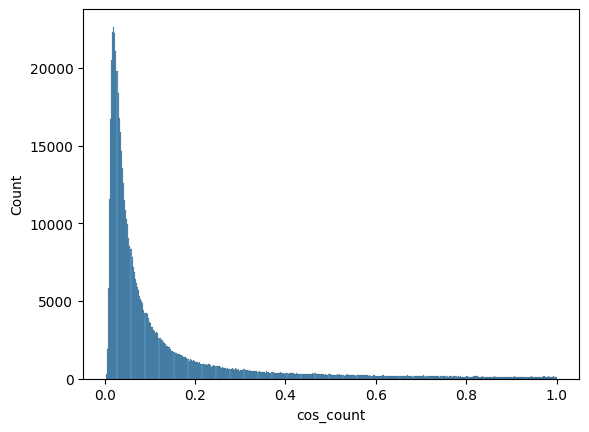

In [91]:
sns.histplot(large_df, x = 'cos_count')

Representative Example

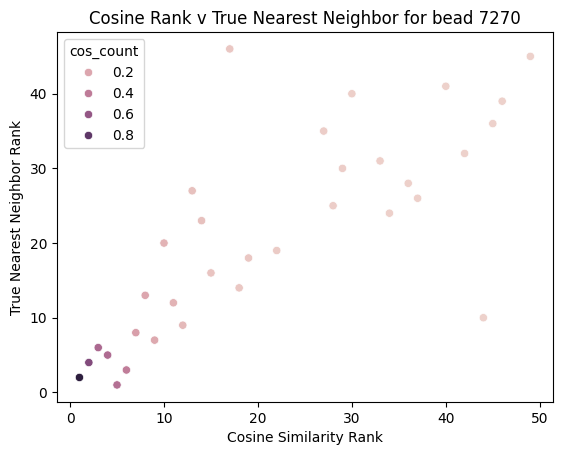

In [92]:
np.random.seed(42)
test = np.random.randint(0, adata.shape[0])
sns.scatterplot(large_df[(large_df.row_bead == test)], y = 'truth_rank', x = 'cos_rank', hue = 'cos_count')
plt.xlabel('Cosine Similarity Rank')
plt.ylabel('True Nearest Neighbor Rank')
plt.title(f'Cosine Rank v True Nearest Neighbor for bead {test}')
plt.savefig('final_figures/Supp3b.png')

Subset to 10 nearest neighbors

In [93]:
large_df = large_df[large_df.truth_rank <= 10]

Percent of 10 nearest neighbors that are within 2 rankings of truth

In [94]:
np.sum(np.abs(large_df.cos_rank - large_df.truth_rank) <= 2)/large_df.shape[0]

np.float64(0.5102394072934349)

Percent of 10 nearest neighbors whose rankings are perfectly accurate

In [95]:
np.sum(large_df.cos_rank == large_df.truth_rank)/large_df.shape[0]

np.float64(0.14364437606094307)

Average number of true nearest neighbors within the top 10 cosine nearest neighbors

In [96]:
large_df[large_df.cos_rank <= 10].groupby(['row_bead']).count()['truth_rank'].mean()

np.float64(7.334358889073673)

Average number of true nearest neighbors within the top 1 cosine nearest neighbors

In [108]:
large_df = large_df[large_df.cos_rank == 1]
np.sum(large_df.truth_rank == 1)/large_df.shape[0]

np.float64(0.4415354827847462)